In [68]:
# import
import os
import pandas as pd
import numpy as np
import nibabel as nib
import shutil
from scipy.ndimage import zoom
from joblib import Parallel, delayed
from tqdm import tqdm
import psutil
import io
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.models as models
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report,precision_recall_curve,roc_curve,accuracy_score, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

from pathlib import Path

In [69]:
class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()

        target = output.squeeze()
        target.backward()

        # Extract gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute weights
        weights = np.mean(gradients, axis=(1, 2, 3))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :, :]

        cam = np.maximum(cam, 0)  # ReLU

        # Upsample CAM to match original input size
        cam_tensor = torch.tensor(cam, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
        cam_upsampled = F.interpolate(
            cam_tensor, size=input_tensor.shape[2:], mode="trilinear", align_corners=False
        )  # Match original size
        cam_upsampled = cam_upsampled.squeeze().cpu().numpy()

        return cam_upsampled / np.max(cam_upsampled)  # Normalize to [0, 1]

In [70]:
# BasicBlock3D 정의
class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.3):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.dropout = nn.Dropout3d(p=dropout_prob)  # Dropout 추가

        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Dropout 적용
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return F.relu(out)


# ResNet18-3D 정의
class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet3D, self).__init__()
        self.in_channels = 64

        # 초기 Conv 레이어
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        # ResNet Layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Global Average Pooling과 FC 레이어
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# ResNet18-3D 생성 함수
def resnet18_3d():
    return ResNet3D(BasicBlock3D, [2, 2, 2, 2])


def register_hooks_for_tensorboard(model, writer):
    def hook_fn(module, input, output):
        # Step을 TensorBoard에서 사용하기 위해 전역 변수 가져오기
        global global_step

        # Conv3D나 BatchNorm3D의 출력 feature를 이미지로 저장
        if output.dim() == 5:  # 3D 텐서 [batch, channel, depth, height, width]
            # 첫 번째 샘플(batch)만 확인
            feature_map = output[0]  # Shape: [channel, depth, height, width]

            # 첫 번째 채널의 중간 depth 슬라이스를 저장
            middle_slice = feature_map[0, feature_map.shape[1] // 2, :, :]  # Shape: [height, width]
            writer.add_image(f"{module._get_name()}_feature_map", middle_slice.cpu().detach().numpy(), global_step, dataformats="HW")

            # 전체 채널의 평균을 계산하여 대표 슬라이스 저장 (2D로 축소)
            mean_feature = torch.mean(feature_map, dim=0)  # Shape: [depth, height, width]
            mean_slice = mean_feature[mean_feature.shape[0] // 2, :, :]  # Shape: [height, width]
            writer.add_image(f"{module._get_name()}_mean_feature_map", mean_slice.cpu().detach().numpy(), global_step, dataformats="HW")

    # Hook 등록: Conv3D, BatchNorm3D, BasicBlock3D 레이어 대상
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv3d, nn.BatchNorm3d, BasicBlock3D)):
            module.register_forward_hook(hook_fn)


# 학습 루프
def train_model(model, train_loader, criterion, optimizer, writer, device, epochs):
    global global_step
    global_step = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, (volumes, scores) in enumerate(train_loader):
            global_step += 1

            volumes, scores = volumes.to(device), scores.to(device)

            optimizer.zero_grad()
            outputs = model(volumes)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # TensorBoard에 Loss 기록
            writer.add_scalar("Loss/Train", loss.item(), global_step)

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")


In [71]:
#nii 파일 로드 + 전처리 함수들
# NIfTI 파일 로드
def load_nii(file_path):
    try:
        data = nib.load(file_path).get_fdata(dtype=np.float32)
        if data.ndim == 4 and data.shape[-1] == 1:
            data = data.squeeze(axis=-1)
        elif data.ndim != 3:
            raise ValueError(f"Unexpected data dimensions: {data.shape}. Expected 3D data.")
        return data
    except Exception as e:
        print(f"Error loading NIfTI file {file_path}: {e}")
        return None

# PyTorch 기반 리사이즈 함수
def resize_volume_torch(volume, target_shape=(256, 256, 256)):
    try:
        volume_tensor = torch.tensor(volume, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
        resized = F.interpolate(volume_tensor, size=target_shape, mode='trilinear', align_corners=False)
        return resized.squeeze().numpy()
    except Exception as e:
        print(f"Error resizing volume: {e}")
        return None

# 단일 파일 처리
def process_file(file_name, mmse_score, base_path, target_shape):
    file_path = os.path.join(base_path, file_name)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    volume = load_nii(file_path)
    if volume is None:
        return None

    resized_volume = resize_volume_torch(volume, target_shape)
    if resized_volume is None:
        return None

    return [resized_volume, mmse_score]

In [72]:
# def visualize_cam(original, cam, output_dir, slice_axis=2):
#     output_dir = Path(output_dir)
#     output_dir.mkdir(parents=True, exist_ok=True)
#     # 텐서를 numpy로 변환
#     original = original.cpu().squeeze().numpy() if isinstance(original, torch.Tensor) else original
#     print(f"cam : {cam.shape}")
#     cam = cam.cpu().squeeze().numpy() if isinstance(cam, torch.Tensor) else cam
#     num_slices = original.shape[slice_axis]
#     for i in range(num_slices):
#         if slice_axis == 0:
#             original_slice = original[i, :, :]
#             cam_slice = cam[i, :, :]
#         elif slice_axis == 1:
#             original_slice = original[:, i, :]
#             cam_slice = cam[:, i, :]
#         else:
#             original_slice = original[:, :, i]
#             cam_slice = cam[:, :, i]

#         overlay = original_slice * 0.5 + cam_slice * 0.5

#         plt.figure(figsize=(15, 5))
#         plt.subplot(1, 3, 1)
#         plt.title("Original")
#         plt.imshow(original_slice, cmap="gray")

#         plt.subplot(1, 3, 2)
#         plt.title("CAM")
#         plt.imshow(cam_slice, cmap="jet")

#         plt.subplot(1, 3, 3)
#         plt.title("Overlay")
#         plt.imshow(overlay, cmap="hot")

#         plt.savefig(output_dir / f"slice_{i:03d}.png")
#         plt.close()

def normalize_to_range(data, min_val=0, max_val=1):
    data_min = np.min(data)
    data_max = np.max(data)
    if data_max - data_min == 0:  # Avoid division by zero
        return np.zeros_like(data)
    return (data - data_min) / (data_max - data_min) * (max_val - min_val) + min_val

def visualize_cam(original, cam, output_dir, slice_axis=2):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # 텐서를 numpy로 변환
    original = original.cpu().squeeze().numpy() if isinstance(original, torch.Tensor) else original
    cam = cam.cpu().squeeze().numpy() if isinstance(cam, torch.Tensor) else cam

    num_slices = original.shape[slice_axis]
    for i in range(num_slices):
        if slice_axis == 0:
            original_slice = normalize_to_range(original[i, :, :])
            cam_slice = cam[i, :, :]
        elif slice_axis == 1:
            original_slice = normalize_to_range(original[:, i, :])
            cam_slice = cam[:, i, :]
        else:
            original_slice = normalize_to_range(original[:, :, i])
            cam_slice = cam[:, :, i]

        overlay = original_slice * 0.5 + cam_slice * 0.5

        vmin = 0
        vmax = 1
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(original_slice, cmap="gray",vmin=vmin, vmax=vmax)
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title("CAM")
        plt.imshow(cam_slice, cmap="jet", vmin = vmin , vmax = vmax)
        plt.colorbar()

        # plt.subplot(1, 3, 3)
        # plt.title("Overlay")
        # plt.imshow(overlay, cmap="jet")

        plt.savefig(output_dir / f"slice_{i:03d}.png")
        plt.close()


C:\Users\user\AppData\Local\Temp\ipykernel_33612\124779372.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


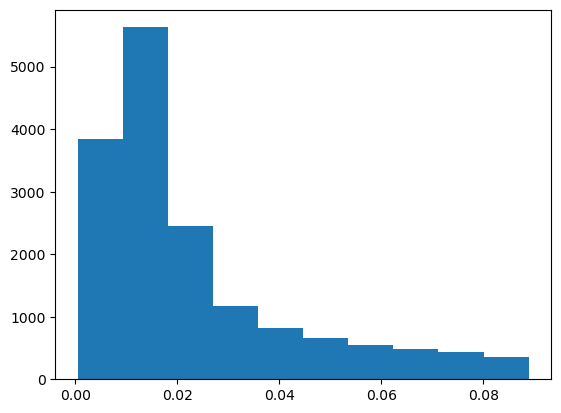

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'resnet3d_18_epoch50_26_0_49.pth'
nii_path = '2021-07-13,I1467526_resized.nii.gz'
output_dir ='./CAM/12251337'

model = resnet18_3d().to(device)
model.load_state_dict(torch.load(model_path))

target_layer = model.layer2[1].conv2
cam_generator = GradCAM3D(model,target_layer)

data = load_nii(nii_path)
data = resize_volume_torch(data,(128,128,128))

data = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [Batch, Channel, Depth, Height, Width]

cam = cam_generator.generate_cam(data,target_class=0)

plt.hist(cam[0].reshape(-1))
plt.show()
visualize_cam(data,cam,output_dir,slice_axis=0)